# Define the problem

# How can we identify the disasters through tweets?

<i> Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies)<br>

But, it’s not always clear whether a person’s words are actually announcing a disaster. Through this project we want to solve this problem using some advanced technologies of NLP and accuratley classify between emergency and non-emergency tweets.</i>

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import os
import io
import json

import sys
sys.path.insert(1, '../src')

from features import build_features as bf
from visualization import visualize as vs
from models import train_model as tm

from os import path
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import string

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Tensorflow libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional,GlobalMaxPooling1D, Embedding,BatchNormalization, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import model_from_json

### Loading the Data

In [2]:
tweet_data = pd.read_csv('../data/raw/train.csv')
tweet_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


##  Checking out null values

<i>Missing values

In [3]:
tweet_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

<i>Missing values Percentage

In [4]:
(tweet_data.isnull().sum()/len(tweet_data))*100

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

## Cleaning the data

<i>The most values we are missing is location and we dont have any other data to replace it.<br>Lets replace the missing key words with <b>"NAN"</b> and drop the location column</i>

In [5]:
def cleaning_data(tweet_data):
    tweet_data = tweet_data.drop(labels=["location", "id"], axis=1)
    tweet_data['keyword'] = tweet_data['keyword'].replace(np.nan, "NAN")
    print((tweet_data.isnull().sum()/len(tweet_data))*100)
    return tweet_data

In [6]:
tweet_data = cleaning_data(tweet_data)

keyword    0.0
text       0.0
target     0.0
dtype: float64


## Exploring the Data (EDA)

<i>Lets check out if we equal proportion of the data</i>

In [7]:
tweet_data.groupby("target").count()

,keyword,text
target,,
0,4342,4342
1,3271,3271


<i>It looks like we have slightly more non-disaster value compared to disaster value but<br>
there is no wide gap.</i>

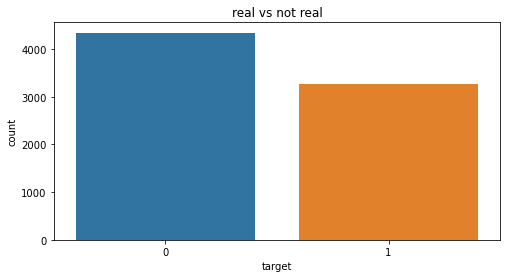

In [8]:
vs.proportion(tweet_data)

<i>We can see that overall not disaster tweets have more words<br>
compared to disaster tweets.</i>

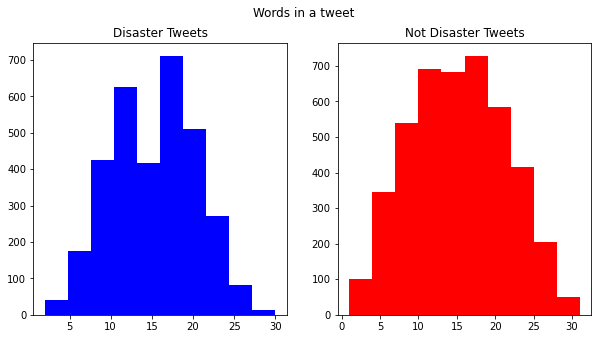

In [9]:
vs.word_count(tweet_data)

<i>The avg word length is very similar.</i>

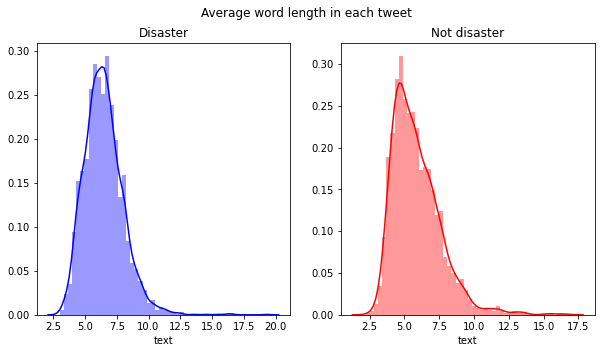

In [10]:
vs.avg_word_length(tweet_data)

<i>We can see that disaster tweets usally have <b>"Fire, Suicide bombing, car crash e.t.c"</b> <br>and non disaster has more words like <b>"love, people,good e.t.c "</b>
 <br>
    <br>
    We can see the keywords are a better indicator distinguishing between disaster and non disaster.</i>

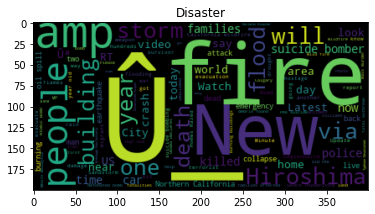

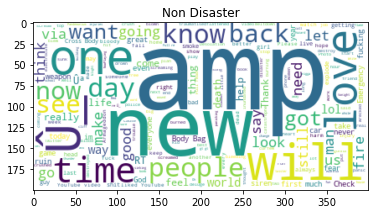

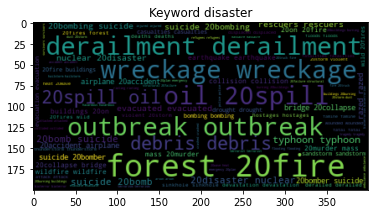

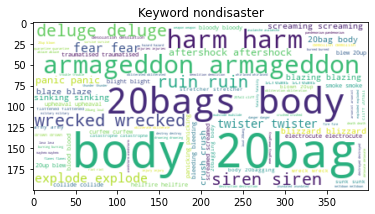

In [11]:
vs.word_cloud(tweet_data)

In [12]:
def create_corpus(target):
    corpus = []
    for words in tweet_data[tweet_data['target'] == target]['text'].str.split():
        for word in words:
            corpus.append(word)
    return corpus

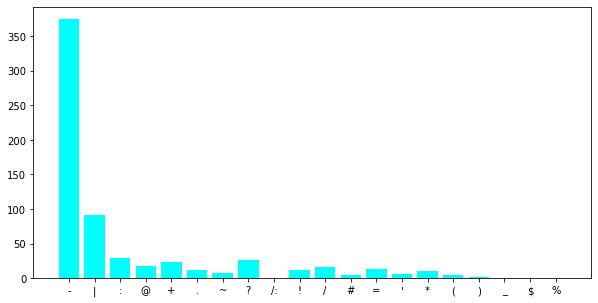

In [13]:
corpus = create_corpus(0)
vs.punctuations(corpus)

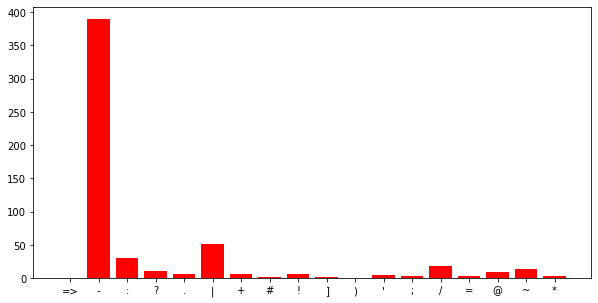

In [14]:
corpus = create_corpus(1)
vs.punctuations(corpus, color='red')

## --Preprocessing the data--

<h4> Preprocessing the data is a very important step in NLP </h4><br>

<b> Step 1: Shuffling the Data</b><br>
<i> It is very important to shuffle the data to make sure that when we split the data we do not end up with imblanced classes that is we dont want to many emergency examples in our training or test data vice versa.</i><br><br>

<b> Step 2: Combine the keywords with text</b><br>
<i> After closley looking at the data we realized that <b>'keyword'</b> column is actually a subspace of the <b>'text'</b>.<br> For example,<br> keyword: bomb<br> text: There is a man with a bomb and the bomb is placed in the building <br> As you can see the bomb is represented in the text multiple times as well as the keyword.<br><br>
    
<b> Step 3: Removing Stop words, Links and emojis</b><br>
<i>Stop words are the words we use quite often in our language but hold a little are almost no meaning. 
    <br>For example, <b>'The', 'by', 'a', e.t.c </b> compared to <b> 'person', 'bomd', 'love', e.t.c</b> <br> By getting rid of this stop words we save a lot of computational time as well as help our NLP model to easily understand</i>
<br> https links and emojis are too complex for our models to make sense.<br> 

 <b> Step 4: Splitting the Data</b><br>
    <i> We split our train data into train and validation with a 80/20 split as the test data is provided to test it on Kaggle we do not need it.</i><br>
   
<b> Step 5: Tokenization </b><br>
        <i> Tokenization plays a key role in NLP algorithms. We are going to use the tensorflow inbuilt tokenizer library.<br>
            What a tokenizer does is it maps our words in texts to numbers<br>
            For example, Text: <b>"I love you"</b><br>
            will be translated to <b>{"I":1, "love":2, "you":3, "OOV":4}</b><br>
            We are going to use only the texts form our training as we do not want any data lekage in our solution.
    </i><br><br>
    <b> Step 6: Sequencing</b><br>
        <i> We are going to turn our words into sequences <b>"I love you"</b> will be translated to <b>[1,2,3]</b><br><br>
<b> Step 7: Padding</b><br>
            <i> As we want all our data to have the same dimensions we are going to pad the smaller sentenses with <b>0</b> at the end.</i>
    


In [16]:
def pre_processing_data(tweet_data):
    '''
    Tokenizes our data.
    '''
    #random shuffle the data
    tweet_data = tweet_data.sample(frac=1)
    
    #Merging the text with key word
    tweet_data_text = tweet_data['keyword'].str.cat(tweet_data['text'], sep=' ')
    
    #Clean the data
    tweet_data_text = tweet_data_text.apply(lambda text: bf.clean_text(text))
    
    #Remove emojis
    tweet_data_text = tweet_data_text.apply(lambda text: bf.remove_emoji(text))
    
    #Removing Stop words
    tweet_data_text = bf.remove_stopwords(tweet_data_text)
    
    #Train val split
    (train_text, train_labels), (val_text, val_labels) = bf.train_val_split(tweet_data_text, tweet_data['target'])
    
    max_len = len(max(train_text, key= lambda sentence: len(sentence.split())))
    
    #Tokenization
    text_tokenizer = Tokenizer(oov_token='<OOV>')
    
    text_tokenizer.fit_on_texts(train_text)
    
    print(len(text_tokenizer.word_index))
    #Sequencing
    sequences_text_train = text_tokenizer.texts_to_sequences(train_text)
    sequences_labels_train = np.array(train_labels)
    
    sequences_text_val = text_tokenizer.texts_to_sequences(val_text)
    sequences_labels_val = np.array(val_labels)

    #Padding
    
    padded_text_train = pad_sequences(sequences_text_train, padding='post', maxlen=max_len)
    padded_text_val = pad_sequences(sequences_text_val, padding='post', maxlen=max_len)
    
    #Saving the tokenizer
    bf.save_tokenizer(text_tokenizer)
    
    return (padded_text_train, sequences_labels_train),(padded_text_val, sequences_labels_val)

In [17]:
(train_texts, train_labels), (val_texts, val_labels) = pre_processing_data(tweet_data)

14518


## --Establishing a Baseline--

In [14]:
def danger_words():
    '''
    returns The first 5 keywords that are closley associated
    with emergency
    '''
    danger_keyword = tweet_data[tweet_data['target'] == 1].groupby('keyword').count()
    danger_keyword = danger_keyword.sort_values('text',ascending=False).iloc[1:6]
    danger_keyword = danger_keyword.index.values
    return danger_keyword

In [15]:
def baseline(test_data, danger_keyword):
    for word in danger_keyword:
        if(test_data['keyword'] == word):
            test_data['target'] = 1
    return test_data

### -- Evaluating the baseline--

In [16]:
def eval_base():
    '''
    Evaluating the baseline model.
    '''
    danger_keyword = danger_words()
    test_data = pd.read_csv('../data/raw/test.csv')
    test_data['keyword'] = test_data['keyword'].replace(np.nan, "NAN")
    test_data['target'] = 0
    test_data = test_data.apply(lambda x: baseline(x, danger_keyword),axis=1)
    test_data = test_data.drop(['location', 'keyword', 'text'], axis=1)
    test_data.set_index('id').to_csv('../data/external/submission_base.csv')

In [17]:
eval_base()

<i> My First submission with the baseline model resulted in a 0.588 mean F-1 score.
    Lets try to improve this with squence models. and was placed at 1131 of 1273 teams</i>

## --Developing models--

<h4>1. LSTM Model</h4>

<h5> Building the model</h5><br>
<b> What is an LSTM Model?</b><br>
<i> LSTM is an abbrevation for Long Short Term Memory(LSTM) what this means is that in our neural networks we have a <b>memory cell</b> that can store words that might play a key factor in determining what the output might be at the end of the sentence.</i> <br><br>
<b> What is an Word Embedding?</b><br>
<i> A word embedding is a class of approaches for representing words and documents using a dense vector representation.

It is an improvement over more the traditional bag-of-word model encoding schemes where large sparse vectors were used to represent each word or to score each word within a vector to represent an entire vocabulary. These representations were sparse because the vocabularies were vast and a given word or document would be represented by a large vector comprised mostly of zero values</i><br><br>
<b> What is batchnormalization?</b><br>
<i>Batch normalization (also known as batch norm) is a method used to make artificial neural networks faster and more stable through normalization of the input layer by re-centering and re-scaling</i><br><br>
<h5> Callbacks</h5>
<i> We used early stopping callbacks with a patience level of 10 so we do not overfit our validation data</i>

In [45]:
def lstm_model(input_length, dim=[128,64,32], train=(), val=()):
    '''
    LSTM Model
    '''
    with open('../src/models/tokenizer.json') as f:
        data = json.load(f)
        tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)
    
    vocab_len = len(tokenizer.word_index)+1
    
    for out in dim:
        #model
        model = Sequential()
        #Embedding
        model.add(Embedding(vocab_len, out, input_length=input_length))
        #Layer 1
        model.add(Bidirectional(LSTM(input_length, return_sequences=True)))
        model.add(GlobalAveragePooling1D())
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        #Final layer
        model.add(Dense(1, activation='sigmoid'))

        #Early stopping call backs
        callback = tm.callbacks()

        #Complile
        model.compile(loss='binary_crossentropy', optimizer='adam', 
                              metrics=['accuracy'])

        #fit
        history = model.fit(train[0], train[1], validation_data=(val[0], val[1]), epochs =100,
                         callbacks=[callback])

        #Visualize
        vs.training_visualize(history, title='model_LSTM_{}'.format(out))

        #Save model
        tm.save_model(model, title='model_LSTM_{}'.format(out))
        

In [56]:
lstm_model(input_length = train_texts.shape[1], train=(train_texts, train_labels),
          val=(val_texts, val_labels))

<i> The LSTM submission resulted in a F1-Score of 0.76892 and was placed as 847 of 1273 teams which is an improvment from baseline model but let's see if we can do better.</i>

![0](../reports/performance/model_LSTM_128.png)

![0](../reports/performance/model_LSTM_64.png)

![0](../reports/performance/model_LSTM_32.png)

In [ ]:
#2. Glove and LSTM

<b> What is Glove?</b><br>
<i>GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. </i>

In [29]:
def glove_LSTM(input_len, train=(), val=()):
    '''
    Glove LSTM
    '''
    with open('../src/models/tokenizer.json') as f:
        data = json.load(f)
        tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)
        
    vocab_len = len(tokenizer.word_index)+1
    
    dimensions = [100,200,300]
    for dim in dimensions:
        embedding_dict = dict()
        glove_file = open('../data/interim/glove/glove.6B.{}d.txt'.format(dim), encoding='utf8')
        
        for line in glove_file:
            records = line.split()
            word = records[0]
            vector_dimensions = np.asarray(records[1:], dtype='float32')
            embedding_dict[word] = vector_dimensions   
        glove_file.close()
        
        embedding_matrix = np.zeros((vocab_len,dim))
        for word, index in tokenizer.word_index.items():
            embedding_vector = embedding_dict.get(word)
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector
        model = Sequential()
        model.add(Embedding(input_dim=embedding_matrix.shape[0],
                           output_dim = embedding_matrix.shape[1],
                           weights = [embedding_matrix],
                           input_length =input_len ))
        model.add(Bidirectional(LSTM(input_len, 
                                     return_sequences = True,
                                    recurrent_dropout=0.2)))
        model.add(GlobalAveragePooling1D())
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.4))
        
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.3))
        
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(optimizer='adam', loss='binary_crossentropy', 
                      metrics=['accuracy'])
        #Early stopping call backs
        callback = tm.callbacks()
        
        #fit
        history = model.fit(train[0], train[1], validation_data=(val[0], val[1]), epochs =100,
                         callbacks=[callback])

        #Visualize
        vs.training_visualize(history, title='glove_LSTM_{}'.format(dim))

        #Save model
        tm.save_model(model, title='glove_LSTM_{}'.format(dim))

In [39]:
glove_LSTM(input_len = train_texts.shape[1], train=(train_texts, train_labels),
          val=(val_texts, val_labels))

![0](../reports/performance/glove_LSTM_100.png)

![0](../reports/performance/glove_LSTM_200.png)

![0](../reports/performance/glove_LSTM_300.png)

 <i>The glove LSTM submission resulted in a F1-Score of 0.80171 and was places 601 of 1273 which is an improvment from LSTM model but let's see if we can do better.</i>


In [ ]:
#3. Bert

<i> To run bert we need high computational power and access to large space of memory. So instead we decided to run it on Kaggle platform and submit the result from there</i>

<i> We were able to achieve an 0.8271 F1-Score were placed in 336 of 1268 teams in the competition </i>

### --Evaluating the models--

In [34]:
def eval_tokenizer():
    #Replace NAN's and concat columns
    test_data = pd.read_csv('../data/raw/test.csv')
    test_data['keyword'] = test_data['keyword'].replace(np.nan, "NAN")
    test_text = test_data['keyword'].str.cat(test_data['text'], sep=' ')
    
    #Clean the data
    test_text = test_text.apply(lambda text: bf.clean_text(text))
    
    #Remove emojis
    test_text = test_text.apply(lambda text: bf.remove_emoji(text))
    
    #Removing Stop words
    test_text = bf.remove_stopwords(test_text)
    # Clean the data
    
    #Tokenize
    with open('../src/models/tokenizer.json') as f:
        data = json.load(f)
        tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)
    
    sequence_text = tokenizer.texts_to_sequences(test_text)
    padded_text = pad_sequences(sequence_text, padding='post', maxlen=train_texts.shape[1])
    return padded_text, test_data

In [54]:
def lstm_eval():
    text_seq, test_data = eval_tokenizer()
    dim = [128, 64, 32]
    for out in dim:
        json_file = open('../src/models/saved_models/model_model_LSTM_{}.json'.format(out),'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        loaded_model.load_weights('../src/models/saved_models/model_model_LSTM_{}.h5'.format(out))
        print("Loaded model from disk")
        loaded_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
        predictions = loaded_model.predict_classes(text_seq)
        pred = pd.DataFrame(predictions, columns=['target'])
        pred = pd.concat([pred, test_data['id']], axis=1)
        pred.set_index('id').to_csv('../data/external/submission_LSTM_{}.csv'.format(out))

In [1]:
lstm_eval()

In [37]:
def glove_lstm_eval():
    text_seq, test_data = eval_tokenizer()
    dimensions = [100,200,300]
    for out in dimensions:
        json_file = open('../src/models/saved_models/model_glove_LSTM_{}.json'.format(out),'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        loaded_model.load_weights('../src/models/saved_models/model_glove_LSTM_{}.h5'.format(out))
        print("Loaded model from disk")
        loaded_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
        predictions = loaded_model.predict_classes(text_seq)
        pred = pd.DataFrame(predictions, columns=['target'])
        pred = pd.concat([pred, test_data['id']], axis=1)
        pred.set_index('id').to_csv('../data/external/submission_glove_LSTM_{}.csv'.format(out))
        

In [38]:
glove_lstm_eval()

Loaded model from disk
Loaded model from disk
Loaded model from disk
